<a href="https://colab.research.google.com/github/maddieportrey/NFL-Final-Project/blob/main/NFL_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries:

In [1]:
#!pip install shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from shap import Explainer
from shap.plots import beeswarm
import warnings
warnings.filterwarnings("ignore")

Read in csv from data cleaning code and clean/feature engineer data:

- Create new columns through feature engineering (yards, touchdowns, touches)

- Filter out unwanted data by creating minimum requirements for touches and yards

- Group by conferences and filter out insignificant conferences with too little observations

- Get dummy variables for player position

In [23]:
total = pd.read_csv("/content/drive/MyDrive/total.csv")
total['Yards'] = total['passing_yards'] + total['rushing_yards'] + total['receiving_yards'] + total['kick_return_yards'] + total['punt_return_yards']
total['TD'] = total['passing_touchdowns'] + total['rushing_touchdowns'] + total['receiving_touchdowns'] + total['kick_return_touchdowns'] + total['punt_return_touchdowns']
total['Touches'] = total['passing_completions'] + total['receiving_receptions'] + total['rushing_attempts']
total.replace([np.inf, -np.inf], np.nan, inplace=True)
total = total.dropna()

total = total[['player_id','name','position','NCAA_CONFERENCE','Yards','TD','Touches']]
total = total[total['Yards'] > 100]
total = total[total['Touches'] > 0]

counts = total.groupby(['NCAA_CONFERENCE']).size().reset_index(name='counts')
counts = counts[counts['counts'] > 90]
total = pd.merge(total, counts, on='NCAA_CONFERENCE', how='inner')
ID = total[['player_id','name']]
total = total.drop(['player_id','name','counts'], axis=1)
total['position'] = total['position'].astype(str)
total = total.loc[(total['position'].str.contains("QB")) | (total['position'].str.contains("RB")) | (total['position'].str.contains("WR")) | (total['position'].str.contains("TE")), :]

total = pd.get_dummies(total, columns=['position'])

Create several plots visualizing the average number of yards, TDs, and touches between conferences

In [3]:
fig = px.box(total, x="NCAA_CONFERENCE", y="Yards", labels={
    "NCAA_CONFERENCE": "College Conference",
    "Yards": "Yards per Season"})
fig.update_xaxes(categoryorder='category ascending')
fig.update_layout(
    title={
        'text': "Yards by Conference",
        'y':.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [4]:
fig = px.box(total, x = "NCAA_CONFERENCE", y = "TD", labels={
                     "NCAA_CONFERENCE": "College Conference",
                     "TD": "Touchdowns per Season"
                 })
fig.update_xaxes(categoryorder='category ascending')
fig.update_layout(
    title={
        'text': "Touchdowns by Conference",
        'y':.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [5]:
fig = px.box(total, x = "NCAA_CONFERENCE", y = "Touches", labels={
                     "NCAA_CONFERENCE": "College Conference",
                     "Touches": "Touches on the Ball"
                 })
fig.update_xaxes(categoryorder='category ascending')
fig.update_layout(
    title={
        'text': "Touches on the Ball by Conference",
        'y':.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

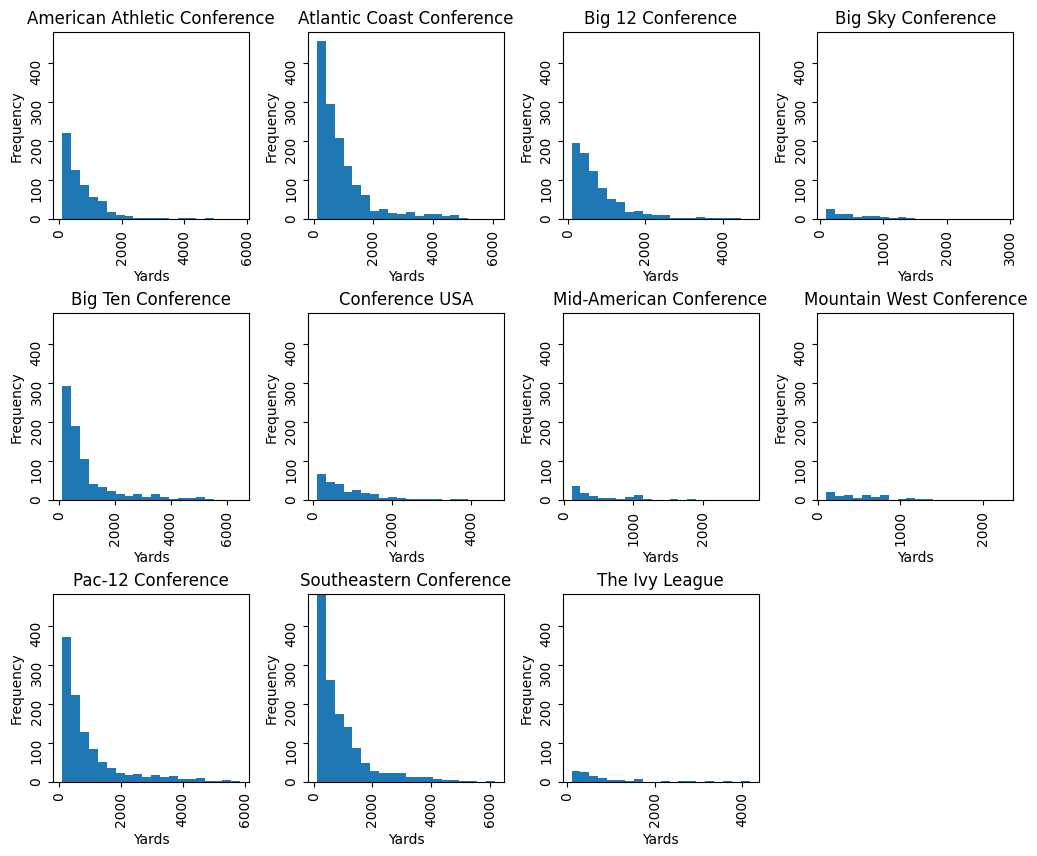

In [6]:
axes = total.hist('Yards', by='NCAA_CONFERENCE', layout=(3,4),
              yrot=90, bins = 20,
              figsize=(12,10))
for ax in axes.flatten():

    ax.set_xlabel('Yards')
    ax.set_ylabel('Frequency')

plt.setp(axes, ylim=axes[0,1].get_ylim());

Train the first model: Linear Regression

- Print recall, precision, and f1 score

In [7]:
y = total['NCAA_CONFERENCE']
X = total.drop('NCAA_CONFERENCE', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create a logistic regression model
modelLR = LogisticRegression(solver='newton-cg')

# fit the model to the training data
modelLR.fit(X_train, y_train)

# make predictions on the test data
y_predLR = modelLR.predict(X_test)

# evaluate the model
print('Recall', recall_score(y_test, y_predLR, average='weighted'))
print('Precision', precision_score(y_test, y_predLR, average='weighted'))
print('F1 Score', f1_score(y_test, y_predLR, average='weighted'))

Recall 0.25045153521974717
Precision 0.34798296956396524
F1 Score 0.21301786180947752


Train the next model: Random Forest

- Print recall, precision, and f1 score

In [8]:
# create a random forest model
modelRF = RandomForestClassifier(n_estimators=100)

# fit the model to the training data
modelRF.fit(X_train, y_train)

# make predictions on the test data
y_predRF = modelRF.predict(X_test)

# evaluate the model
print('Recall', recall_score(y_test, y_predRF, average='weighted'))
print('Precision', precision_score(y_test, y_predRF, average='weighted'))
print('F1 Score', f1_score(y_test, y_predRF, average='weighted'))

Recall 0.2107164358819988
Precision 0.20236676110283788
F1 Score 0.20581982668227441


Train the first model: Random Forest again, but hypertune parameters to improve performance

- Print recall, precision, and f1 score

In [9]:
# create another random forest model
modelRF2 = RandomForestClassifier(n_estimators=100)

# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(modelRF2, param_grid, cv=5)

# fit the model to the training data
grid_search.fit(X_train, y_train)

# make predictions on the test data
y_predRF2 = grid_search.predict(X_test)

# evaluate the model
print('Recall', recall_score(y_test, y_predRF2, average='weighted'))
print('Precision', precision_score(y_test, y_predRF2, average='weighted'))
print('F1 Score', f1_score(y_test, y_predRF2, average='weighted'))

Recall 0.24864539434075858
Precision 0.35841373413551425
F1 Score 0.1927915978048457


Train the next model: Decision Tree

- Print recall, precision, and f1 score

In [10]:
# create a decision tree model
modelDT = DecisionTreeClassifier()

# hyperparameter tuning
parameters = {'max_depth': [5, 10, 20, 50], 'min_samples_split': [2, 5, 10, 20]}
grid_search = GridSearchCV(modelDT, parameters, n_jobs=-1)

# fit the model to the training data
grid_search.fit(X_train, y_train)

# make predictions on the test data
y_predDT = grid_search.predict(X_test)

# evaluate the model

print('Recall', recall_score(y_test, y_predDT, average='weighted'))
print('Precision', precision_score(y_test, y_predDT, average='weighted'))
print('F1 Score', f1_score(y_test, y_predDT, average='weighted'))

Recall 0.2275737507525587
Precision 0.2144863950966347
F1 Score 0.1643628817940952


Train the next model: SVM

- Print recall, precision, and f1 score

In [11]:
# create a support vector machine model
modelSVM = SVC()

# hyperparameter tuning
parameters = {'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1]}
grid_search = GridSearchCV(modelSVM, parameters, n_jobs=-1)

# fit the model to the training data
grid_search.fit(X_train, y_train)

# make predictions on the test data
y_predSVM = grid_search.predict(X_test)

# evaluate the model
print('Recall', recall_score(y_test, y_predSVM, average='weighted'))
print('Precision', precision_score(y_test, y_predSVM, average='weighted'))
print('F1 Score', f1_score(y_test, y_predSVM, average='weighted'))

Recall 0.2721252257676099
Precision 0.3832792539640187
F1 Score 0.21990928426413567


Output best parameters from last model

In [12]:
grid_search.best_params_

{'C': 10, 'gamma': 0.1}

Train the next model: AdaBoost

- Print recall, precision, and f1 score

In [13]:
# create an AdaBoost model
modelAB = AdaBoostClassifier(n_estimators=100)

# hyperparameter tuning
parameters = {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.1, 0.5, 1]}
grid_search = GridSearchCV(modelAB, parameters, n_jobs=-1)

# fit the model to the training data
grid_search.fit(X_train, y_train)

# make predictions on the test data
y_predAB = grid_search.predict(X_test)

# evaluate the model
print('Recall', recall_score(y_test, y_predAB, average='weighted'))
print('Precision', precision_score(y_test, y_predAB, average='weighted'))
print('F1 Score', f1_score(y_test, y_predAB, average='weighted'))

Recall 0.22456351595424442
Precision 0.4005369554896967
F1 Score 0.15896568370529046


Put all the scores together in one dataframe and export as a table

In [14]:
df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Random Forest - Tuned', 'Decision Tree', 'Support Vector Machine', 'AdaBoost'],
    'F1 Score': [f1_score(y_test, y_predLR, average='weighted'), f1_score(y_test, y_predRF, average='weighted'), f1_score(y_test, y_predRF2, average='weighted'), f1_score(y_test, y_predDT, average='weighted'), f1_score(y_test, y_predSVM, average='weighted'), f1_score(y_test, y_predAB, average='weighted')],
    'Recall': [recall_score(y_test, y_predLR, average='weighted'), recall_score(y_test, y_predRF, average='weighted'), recall_score(y_test, y_predRF2, average='weighted'), recall_score(y_test, y_predDT, average='weighted'), recall_score(y_test, y_predSVM, average='weighted'), recall_score(y_test, y_predAB, average='weighted')],
    'Precision': [precision_score(y_test, y_predLR, average='weighted'), precision_score(y_test, y_predRF, average='weighted'), precision_score(y_test, y_predRF2, average='weighted'), precision_score(y_test, y_predDT, average='weighted'), precision_score(y_test, y_predSVM, average='weighted'), precision_score(y_test, y_predAB, average='weighted')]
})

In [16]:
#!pip install dataframe_image
import dataframe_image as dfi
dfi.export(
    df,
    "/content/drive/My Drive/scores.png",
    table_conversion="matplotlib"
)


Reduce the dimensionality of the data and find the optimal number of clusters, plot

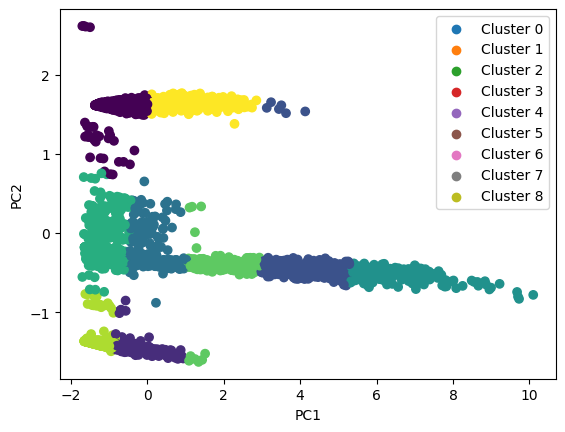

In [17]:
# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# reduce the dimensionality of the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# find the optimal number of clusters using the silhouette score
scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca)
    scores.append(silhouette_score(X_pca, kmeans.labels_))

# select the number of clusters with the highest silhouette score
k = np.argmax(scores) + 2

# train the k-means model with the optimal number of clusters
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(X_pca)

# predict the cluster labels for each data point
y_pred = kmeans.predict(X_pca)

# plot the data points with their cluster labels
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.xlabel("PC1")
plt.ylabel("PC2")
labels = ["Cluster {}".format(i) for i in range(k)]
handles = [plt.scatter([], [], c=c) for c in plt.cm.get_cmap("tab10").colors]
plt.legend(handles, labels)
plt.show()

In [18]:
import shap
shap.initjs()

Use SHAP to visualize variable importance

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

explainer = Explainer(modelLR, X_train)
shap_values = explainer.shap_values(X_test)

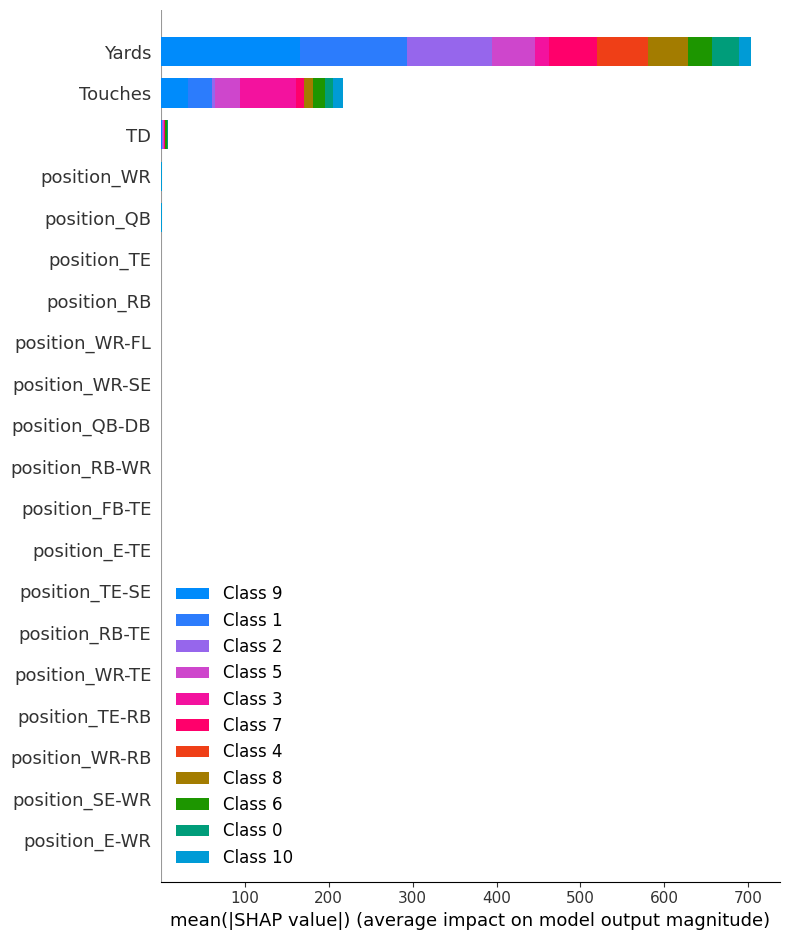

In [20]:
shap.summary_plot(shap_values, X_test)

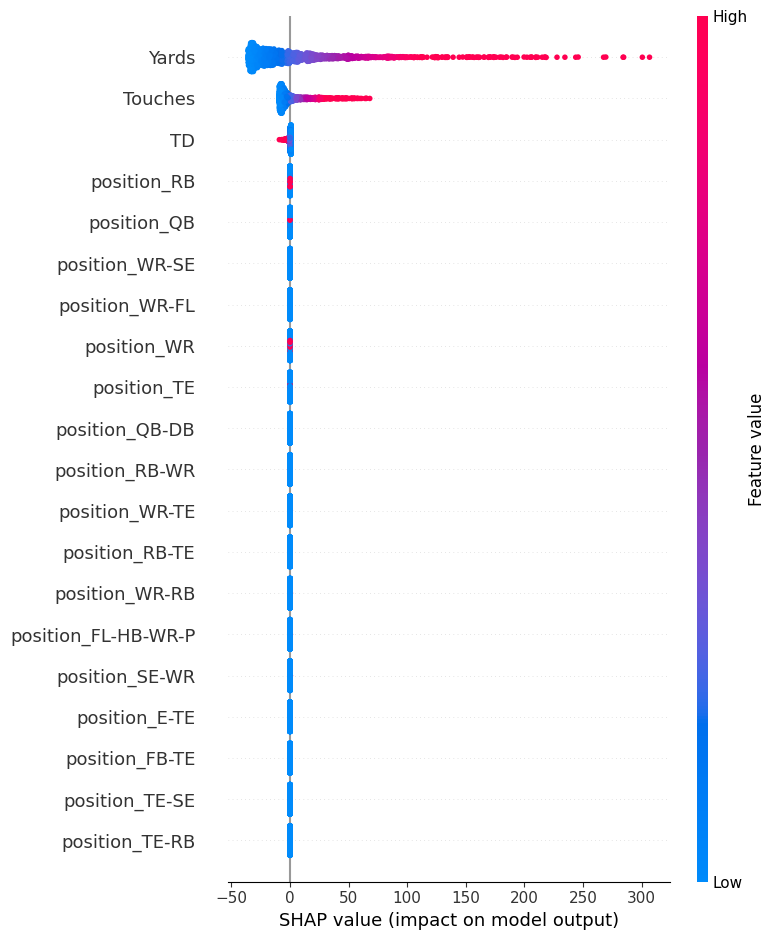

In [21]:
shap.summary_plot(shap_values[0], X_test)

Create a confusion matrix for the best model (SVM)

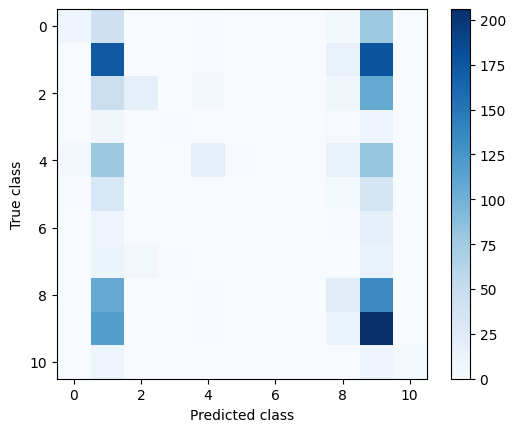

In [22]:
cm = confusion_matrix(y_test, y_predSVM)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.colorbar()
plt.show()
